<a href="https://colab.research.google.com/github/guowenbin90/ICD-coding/blob/main/icd_codex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ICD Codex demo

In [2]:
!pip install icdcodex

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.7 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.1
    Uninstalling networkx-3.1:
      Successfully uninstalled networkx-3.1


In [4]:
from icdcodex import hierarchy
icd_10_cm_hierarchy, icd_10_cm_codes = hierarchy.icd10cm("2020")

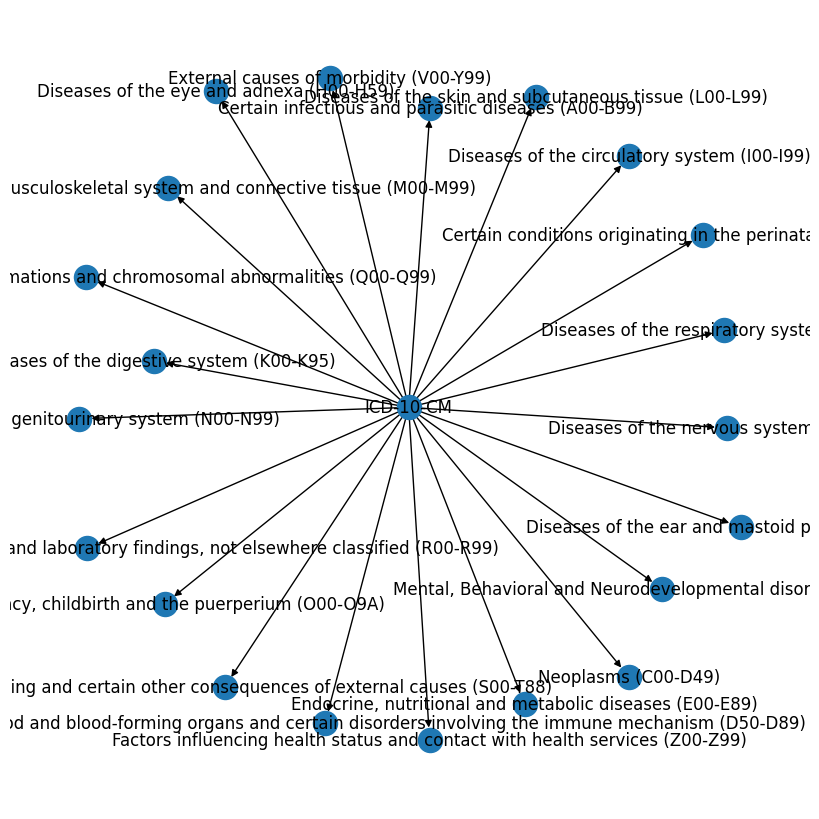

In [5]:
import networkx as nx
from networkx.algorithms.traversal.breadth_first_search import bfs_tree
import matplotlib.pyplot as plt

G = nx.relabel_nodes(icd_10_cm_hierarchy, {"root": "ICD-10-CM"})
G_chapters = bfs_tree(G, "ICD-10-CM", depth_limit=1)
plt.figure(figsize=(8,8))
nx.draw(G_chapters, with_labels=True)

In [18]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
df = pd.read_csv("/content/drive/My Drive/2023AI-QI/icd-codex/data.csv").rename(columns={
    "los": "length_of_stay",
    "dob": "date_of_birth",
    "dod": "date_of_death",
    "admittime": "date_of_admission"
})
df["date_of_birth"] = pd.to_datetime(df["date_of_birth"]).dt.date
df["date_of_death"] = pd.to_datetime(df["date_of_death"]).dt.date
df["date_of_admission"] = pd.to_datetime(df["date_of_admission"]).dt.date
df["age"] = df.apply(lambda e: (e['date_of_admission'] - e['date_of_birth']).days/365, axis=1)
df = df[df.seq_num == 1]  # we limit ourselves to the primary diagnosis code for simplicity
df.gender = LabelEncoder().fit_transform(df.gender)
G, icd_codes = hierarchy.icd9()
df = df[df.icd9_code.isin(G.nodes())]
features = ["length_of_stay", "gender", "age"]
X = df[features].values
y = df[["icd9_code"]].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
from sklearn.ensemble import RandomForestRegressor
y_train_continuous = embedder.to_vec(y_train.reshape(-1))
clf = RandomForestRegressor()
clf.fit(X_train, y_train_continuous)

RandomForestRegressor()